# Introduction

## OCR Pipeline Exploration with Digital Image Processing

This notebook explores an Optical Character Recognition (OCR) pipeline using various digital image processing techniques. 
We will preprocess images, run OCR to recognize text, and evaluate the accuracy of the recognized text. 

# Import Necessary Libraries and Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import os
import pickle
import random
import sys
from pathlib import Path

import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from ipywidgets import interact

part1_dir = os.path.join(os.getcwd(), '..')
sys.path.insert(0, part1_dir)
src_dir = os.path.join(part1_dir, 'src')
sys.path.insert(0, src_dir)

from src.prepare import extract_zip
from src.preprocess import preprocess_image, load_image, enhance_contrast, detect_and_zoom_plate, reduce_noise, apply_threshold, morphological_operations
from src.segment import segment_image
from src.extract import extract_features
from src.train import train_classifier
from src.evaluate import evaluate_model, load_model, load_labels, save_metrics, save_predictions

# Load and Display Sample Images

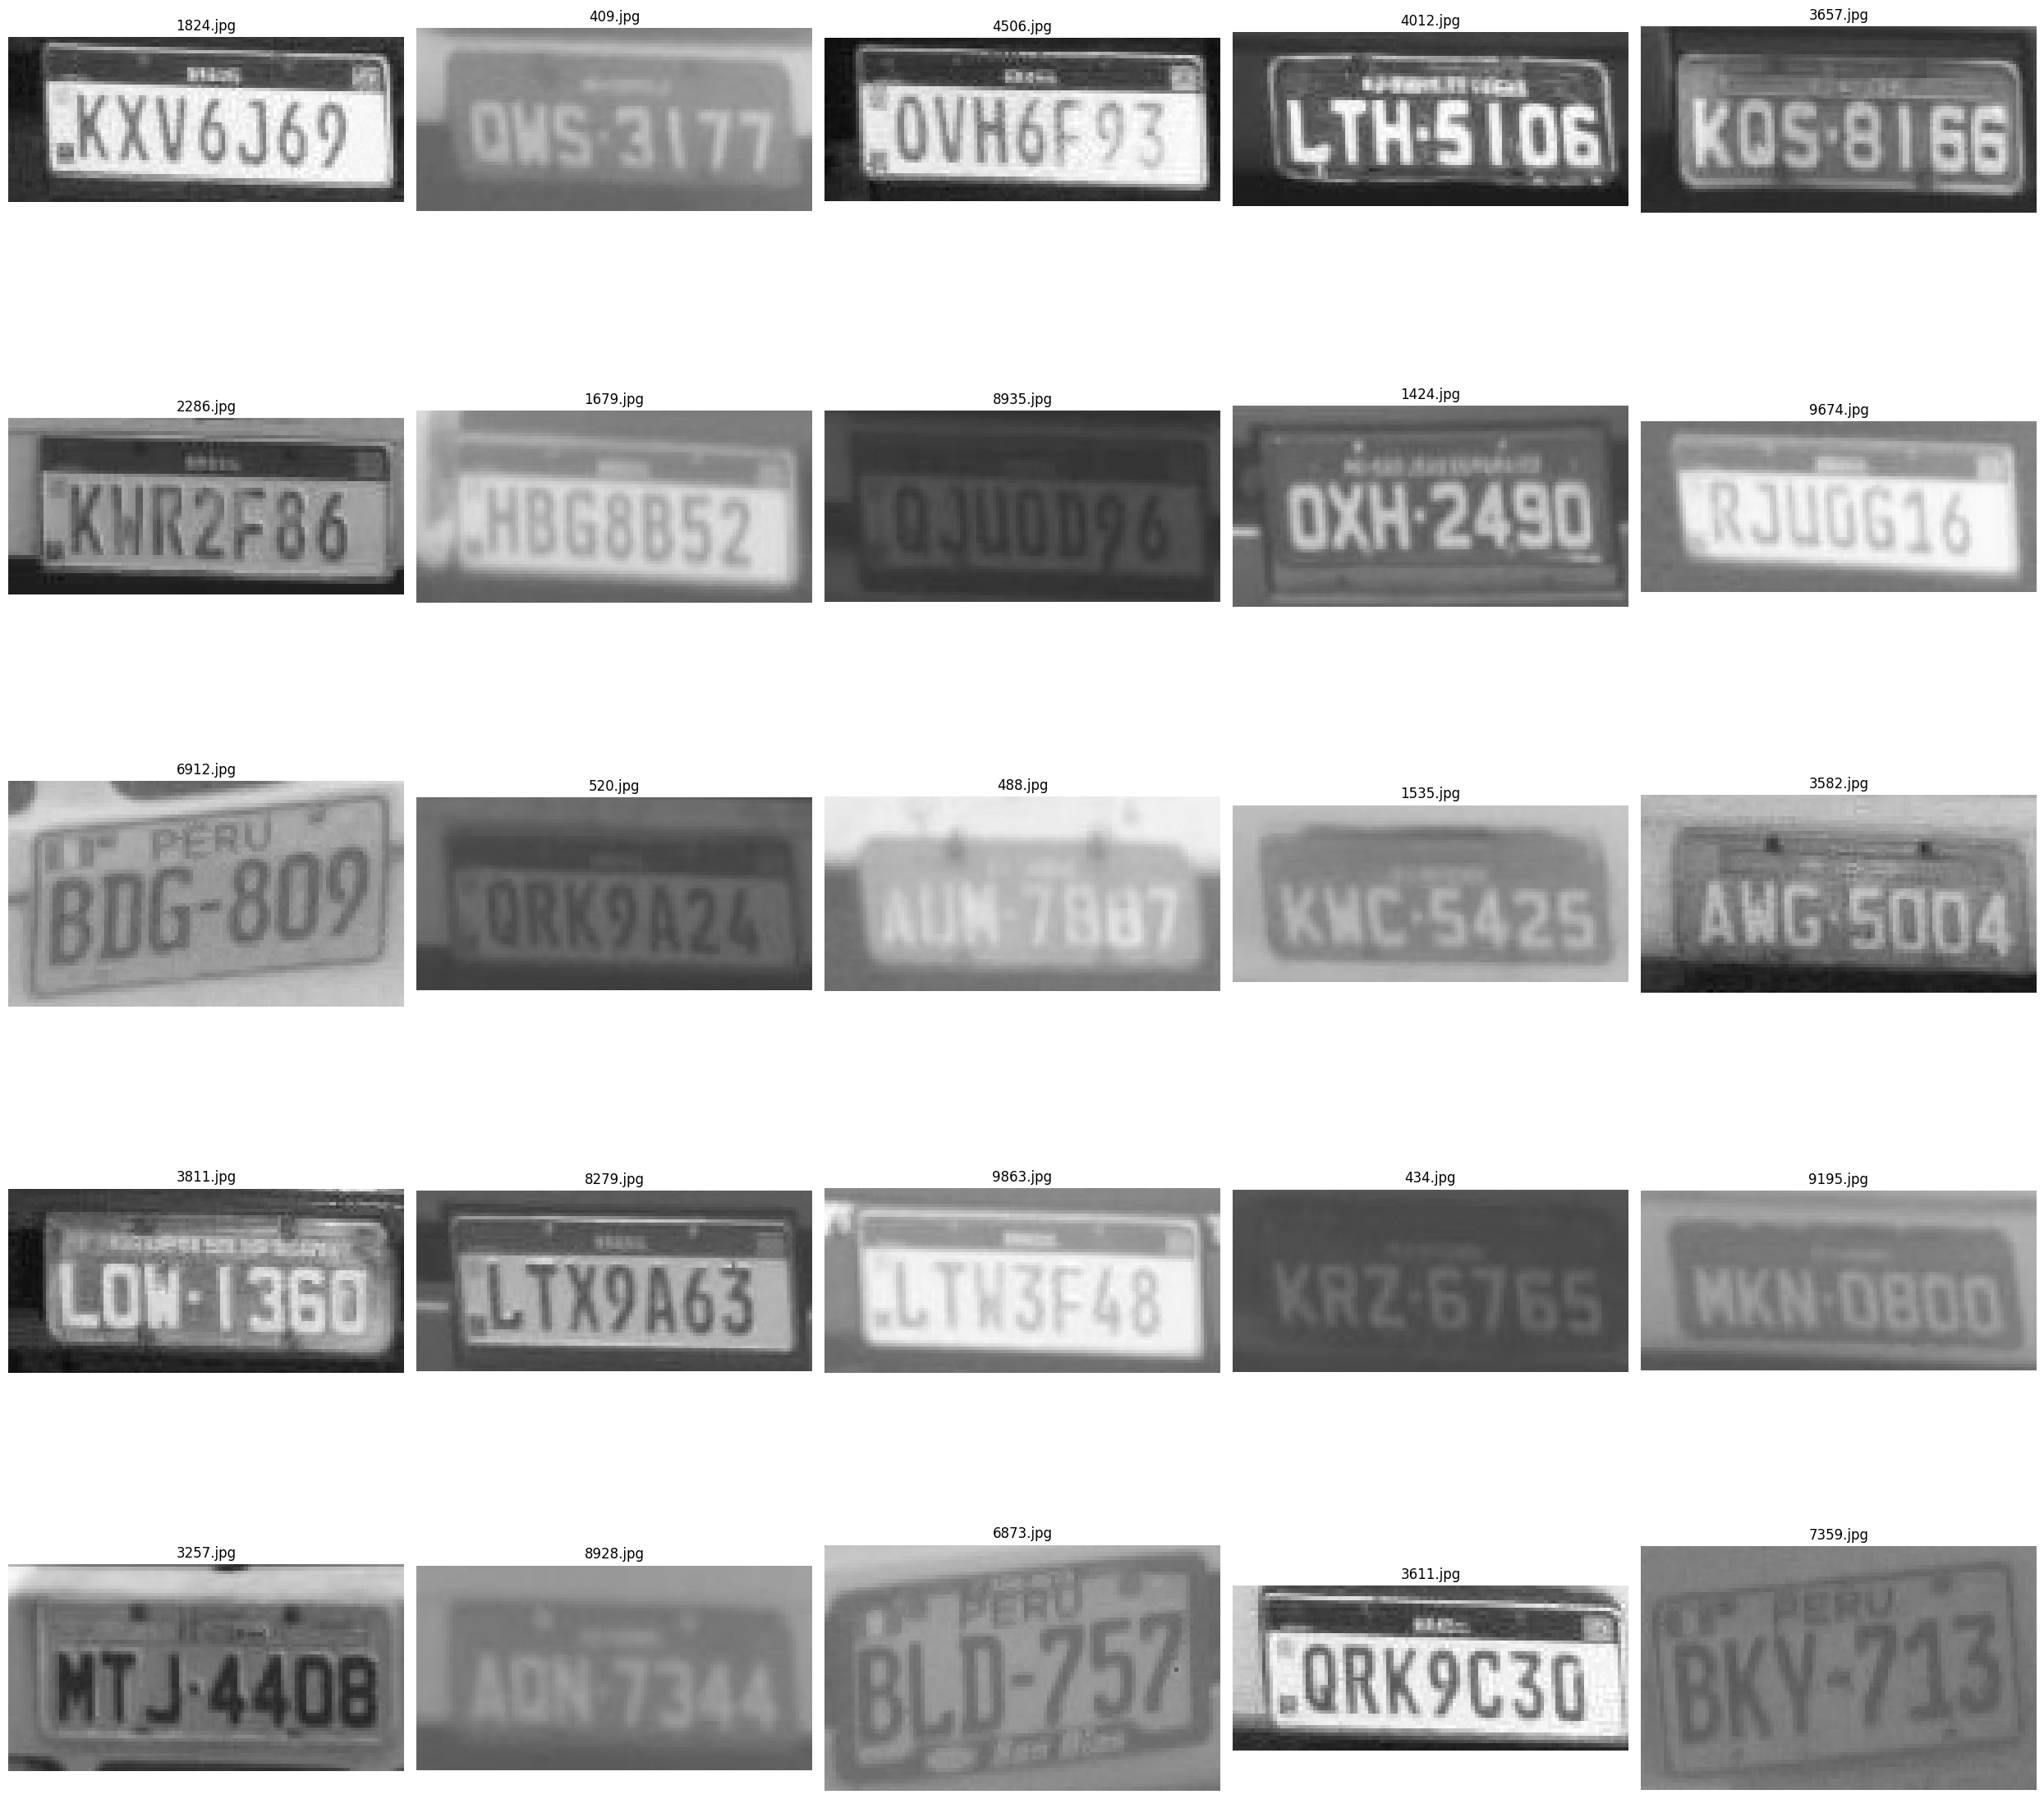

In [42]:
random.seed(42)
data_dir = os.path.join(part1_dir, "data/images/train")
sample_images = random.sample(os.listdir(data_dir), 25)

def display_sample_images(images, rows=1, cols=None):
    """
    Display sample images in a flexible grid of subplots.

    Args:
        images (list): List of image paths.
        rows (int): Number of rows for subplots.
        cols (int): Number of columns for subplots. If None, it will be calculated.
    """
    # Calculate the number of columns if not provided
    if cols is None:
        cols = len(images) // rows + (len(images) % rows > 0)
    
    # Set the figure size dynamically based on the number of rows and columns
    plt.figure(figsize=(cols * 5, rows * 5))
    
    for i, filename in enumerate(images):
        image_path = Path(data_dir, filename)
        image = load_image(image_path)  # Assuming `load_image` function exists to load images
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(image_path.name)
        plt.axis('off')  # Optionally hide axes for better visualization

    plt.tight_layout()
    plt.show()

display_sample_images(sample_images, rows=5)

# Display Results

In [55]:
import ipywidgets as widgets
from ipywidgets import interact, fixed

def display_cropped_characters(image_path, blur_kernel=5, threshold_method='otsu', morph_kernel=3, 
                               min_area=50, max_area=200, connectivity=8, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Display the results of each preprocessing step, original image with bounding boxes,
    and cropped characters for a given image path.

    Args:
        image_path (Path): Path to the image file to be processed.
        min_area (int): Minimum area for connected components to consider.
        connectivity (int): Connectivity for connected component analysis (4 or 8).
        clip_limit (float): Clip limit for CLAHE contrast enhancement. Default is 2.0.
        tile_grid_size (tuple): Tile grid size for CLAHE contrast enhancement. Default is (8, 8).
    """
    image_path = Path(data_dir, image_path)
    # Load the original image
    original_image = load_image(image_path)
    
    # Enhance contrast
    tile_grid_size = (tile_grid_size, tile_grid_size)  # Convert to tuple
    contrast_image = enhance_contrast(original_image, clip_limit=clip_limit, tile_grid_size=tile_grid_size)

    # Reduce noise
    noise_reduced_image = reduce_noise(contrast_image, kernel_size=blur_kernel)
    
    # Detect and zoom plate
    zoomed_plate = detect_and_zoom_plate(noise_reduced_image)
    
    # Apply thresholding
    thresholded_image = apply_threshold(zoomed_plate, method=threshold_method)
    
    # Perform morphological operations
    processed_image = morphological_operations(thresholded_image, kernel=morph_kernel)

    # Perform character segmentation
    bounding_boxes = segment_image(processed_image, min_area=min_area, max_area=max_area, connectivity=connectivity)
    
    # Create a figure to show the results of each preprocessing step
    fig, axs = plt.subplots(1, 7, figsize=(20, 5))
    axs[0].imshow(original_image, cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    axs[1].imshow(contrast_image, cmap='gray')
    axs[1].set_title('Contrast Enhanced')
    axs[1].axis('off')
    
    axs[2].imshow(noise_reduced_image, cmap='gray')
    axs[2].set_title('Noise Reduced')
    axs[2].axis('off')
    
    axs[3].imshow(zoomed_plate, cmap='gray')
    axs[3].set_title('Zoomed Plate')
    axs[3].axis('off')
    
    
    axs[4].imshow(thresholded_image, cmap='gray')
    axs[4].set_title('Thresholded')
    axs[4].axis('off')
    
    axs[5].imshow(processed_image, cmap='gray')
    axs[5].set_title('Morphological Operations')
    axs[5].axis('off')
    
    # Annotate original image with bounding boxes
    annotated_image = cv2.cvtColor(zoomed_plate, cv2.COLOR_GRAY2BGR)  # Convert to BGR for color drawing
    for (x1, y1, x2, y2) in bounding_boxes:
        cv2.rectangle(annotated_image, (x1, y1), (x2, y2), (0, 255, 0), 1)  # Green bounding boxes

    axs[6].imshow(annotated_image)
    axs[6].set_title('Annotated Bounding Boxes')
    axs[6].axis('off')

    plt.suptitle(f"Preprocessing Steps for Image: {image_path.name}")
    plt.tight_layout(rect=[0, 0, 1, 1.35])  # Adjust rect to leave space for suptitle
    plt.show()

# Example interactive widget usage
image_path = sample_images[0]  # Use the first sample image for demonstration

interact(display_cropped_characters,
         image_path=sample_images,
         blur_kernel=widgets.IntSlider(min=1, max=15, step=2, value=5, description='Blur Kernel'),
         threshold_method=widgets.Dropdown(options=['otsu', 'adaptive'], value='otsu', description='Threshold Method'),
         morph_kernel=widgets.IntSlider(min=1, max=10, step=1, value=3, description='Morph Kernel'),
         min_area=widgets.IntSlider(min=1, max=500, step=10, value=50, description='Min Area'),
         max_area=widgets.IntSlider(min=50, max=1000, step=50, value=250, description='Max Area'),
         connectivity=widgets.RadioButtons(options=[4, 8], value=8, description='Connectivity'),
         clip_limit=widgets.FloatSlider(min=0.1, max=10.0, step=0.1, value=2.0, description='CLAHE Clip Limit'),
         tile_grid_size=widgets.IntSlider(min=1, max=20, step=1, value=8, description='Tile Grid Size')
)


interactive(children=(Dropdown(description='image_path', options=('1824.jpg', '409.jpg', '4506.jpg', '4012.jpg…

<function __main__.display_cropped_characters(image_path, blur_kernel=5, threshold_method='otsu', morph_kernel=3, min_area=50, max_area=200, connectivity=8, clip_limit=2.0, tile_grid_size=(8, 8))>

# Conclusion

We have explored the OCR pipeline with various preprocessing steps and hyperparameters. 
You can see how changes in the preprocessing phase affect the segmentation results. 